In [2]:
import psutil
from optmethods.first_order import RestNest
from proxskip.data import W8a_dataset

In [10]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid", context="talk", font_scale=1.2, palette=sns.color_palette("bright"), color_codes=False)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'DejaVu Sans'
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['figure.figsize'] = (9, 6)

In [4]:

num_cpus = psutil.cpu_count(logical=False)
print(num_cpus)

40


In [5]:
dataset = W8a_dataset(num_cpus)

Computing the smoothness constant via SVD, it may take a few minutes...
L: 0.661111067614795, l2: 6.61111067614795e-05


# Nesterov's Method

  0%|          | 0/10000 [00:00<?, ?it/s]

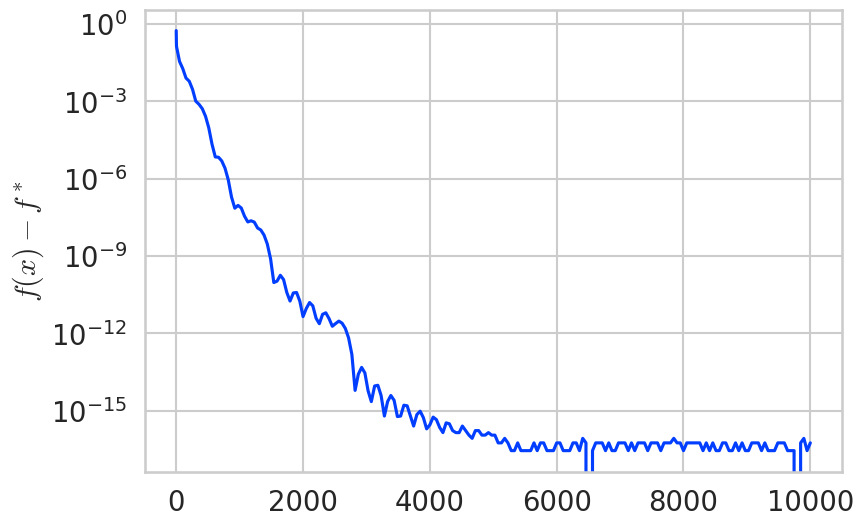

In [7]:

loss, x0,  _, _ = dataset.get_full_data()
rest = RestNest(loss=loss, doubling=True)
rest_tr = rest.run(x0=x0, it_max=10000)
rest_tr.compute_loss_of_iterates()
rest.trace.plot_losses()

plt.yscale('log')

# Non-iid

In [9]:
cohort_size = 20 # CHANGE IF YOU WANT PARTIAL PARTICIPATION
n_workers = 20
n_seeds = 1
batch_size = None

In [11]:
losses = dataset.get_splitted_data(n_workers)
grad_norms = [np.linalg.norm(loss_i.gradient(loss.x_opt))**2 for loss_i in losses]
print(np.mean(grad_norms))

0.0027353411434475204


/usr/local/lib/python3.10/dist-packages/optmethods/loss/logistic_regression.py:44: UserWarning: The labels have only one unique value.
  warnings.warn('The labels have only one unique value.')


In [12]:
if batch_size is not None:
    it_local = 100
    skip_lr0 = 1 / loss.batch_smoothness(batch_size=batch_size) 
    it_max = 2000
    skip_decay_coef = dataset.l2 / 2
else:
    it_local = 100 # same as for other methods
    skip_lr0 = 1 / (loss.smoothness)
    it_max = 2000 # same as before
    skip_decay_coef = 0. # With full gradients, we don't need to decrease the stepsize

In [14]:
from proxskip.methods.proxskip import ProxSkip

skip_lr_max = skip_lr0
skip = ProxSkip(loss=loss, n_workers=n_workers, cohort_size=cohort_size, it_local=it_local, 
               lr_max=skip_lr_max, lr0=skip_lr0, lr_decay_coef=skip_decay_coef, 
               it_start_decay=0, n_seeds=n_seeds, batch_size=batch_size, trace_len=200, iid=False, losses=losses)
skip.run(x0=x0, it_max=it_max)
# sgd.trace.convert_its_to_epochs(batch_size=batch_size*it_local)
skip.trace.compute_loss_of_iterates()
skip.terminate_workers()

2023-12-20 07:59:58,167	WARNING utils.py:581 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2023-12-20 07:59:58,176	WARNING services.py:1996 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 2147479552 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=10.24gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2023-12-20 07:59:59,248	INFO worker.py:1673 -- Started a local Ray instance.


  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
skip.trace.plot_losses(label='ProxSkip:M=20', marker='*', color='blue')

plt.yscale('log')
plt.ylabel(r'$f(x)-f_*$')
plt.xlabel('Communication rounds')
plt.legend()
plt.savefig('linear_speedup.pdf')